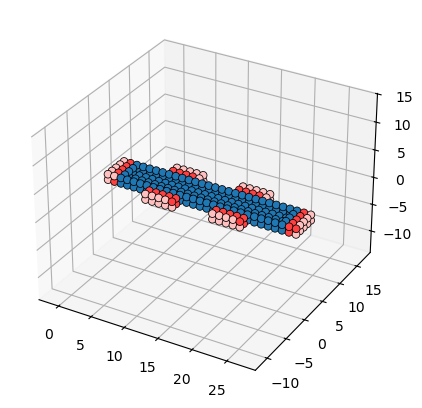

In [77]:
import kwant
import numpy as np
import tinyarray
import matplotlib.pyplot as plt

# Pauli 矩阵和 Γ 矩阵定义（4×4）
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j,  0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4=tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B = -300
g = 300
las = 1.0  # 晶格常数
width = 30

lat = kwant.lattice.cubic(a=las,norbs=4)  # 定义晶格
# 定义双层模型
def make_syst(m, c,width=20, length=100):

    #EG能
    EG_onsite    = (4*c)/las**2 * I_4
    EG_hopping_x = -c/(las**2)*I_4
    EG_hopping_y = -c/(las**2)*I_4 
    EG_hopping_z = 1.0 * I_4
    #TI能
    TI_onsite    = m / 2 * gamma_1 - (4 * B) / (las ** 2) * gamma_2
    TI_hopping_x = B / (las ** 2) * gamma_2 + 1j * g / (2 * las) * gamma_3
    TI_hopping_y = B / (las ** 2) * gamma_2 - 1j * g / (2 * las) * gamma_4
    TI_hopping_z = EG_hopping_z

    # 3D 立方晶格
    
    syst = kwant.Builder()
    # 1) 添加 on-site
    for x in range(1, length+1):
        for y in range(1, width+1):
            for z in (0, 1):
                # 检查是否应该添加此格点
                should_add_site = True
                if z == 1 and 2 <= x <= length-1 and 2<= y <= width-1:
                    should_add_site = False

                if should_add_site:
                    onsite = TI_onsite if z == 0 else EG_onsite
                    syst[lat(x, y, z)] = onsite

    # 2) 添加所有 hopping，分层选择矩阵
    for x in range(1, length+1):
        for y in range(1, width+1):
            for z in (0, 1):
                # 检查当前格点是否存在
                site = lat(x, y, z)
                if site in syst:
                    # x 方向 hopping
                    if x < length:
                        next_site_x = lat(x+1, y, z)
                        if next_site_x in syst: # 检查相邻格点是否存在
                            mat_x = TI_hopping_x if z == 0 else EG_hopping_x
                            syst[site, next_site_x] = mat_x
                    # y 方向 hopping
                    if y < width:
                        next_site_y = lat(x, y+1, z)
                        if next_site_y in syst: # 检查相邻格点是否存在
                            mat_y = TI_hopping_y if z == 0 else EG_hopping_y
                            syst[site, next_site_y] = mat_y
                    # z 方向 hopping （只连 0↔1）
                    if z == 0:
                        next_site_z = lat(x, y, 1)
                        if next_site_z in syst: # 检查上方格点是否存在
                            hopping_z= TI_hopping_z
                            syst[site, next_site_z] = hopping_z


    # lead_model：定义引线的能量模型
    def lead_model():
        structure=kwant.lattice.cubic(las,norbs=4)
        model_sym= kwant.TranslationalSymmetry(structure.vec((1,0,0)),structure.vec((0,-1,0)),structure.vec((0,0,1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0,0,0)] = TI_onsite
        model_1[kwant.builder.HoppingKind((1,0,0), structure)]  = TI_hopping_x
        model_1[kwant.builder.HoppingKind((0,1,0), structure)]  = TI_hopping_y
        model_1[kwant.builder.HoppingKind((0,0,1), structure)]  = TI_hopping_z

        return model_1

    # 引线宽度，沿 x 方向的 leads:
    width_lead = length // 5

    # 定义三个引线，彼此翻转得到 6 个端口
    leads = []
    # lead0：沿 −x 延伸，跨两个层
    lead0 = kwant.Builder(kwant.TranslationalSymmetry((-1, 0, 0)))
    def shape_l0(site):
        x, y, z = site.pos
        return (0 < y <= width) and (0 <= z < 2)
    lead0.fill(lead_model(), shape_l0, (0, 1, 0))
    leads.append(lead0)

    # lead1：沿 +y 延伸，跨两个层
    lead1 = kwant.Builder(kwant.TranslationalSymmetry((0, 1, 0)))
    def shape_l1(site):
        x, y, z = site.pos
        return (width_lead < x <= 2*width_lead) and (0 <= z < 2)
    lead1.fill(lead_model(), shape_l1, (width_lead+1, 0, 0))
    leads.append(lead1)

    # lead2：沿 +y 延伸，不同 x 区间
    lead2 = kwant.Builder(kwant.TranslationalSymmetry((0, 1, 0)))
    def shape_l2(site):
        x, y, z = site.pos
        return (3*width_lead < x <= 4*width_lead) and (0 <= z < 2)
    lead2.fill(lead_model(), shape_l2, (3*width_lead+1, 0, 0))
    leads.append(lead2)

    # attach leads and their reversed copies
    for ld in [leads[0], leads[1], leads[2], leads[0].reversed(), leads[2].reversed(), leads[1].reversed()]:
        syst.attach_lead(ld)

    return syst.finalized()

syst3d = make_syst(m=30,c= 1,width=5, length=25)
fig = kwant.plot(syst3d, fig_size=(5, 5))
plt.show()

In [54]:
# 1. 指定你要查询的格点
site = lat(1, 1, 0)
# 2. 找到它在系统中的“站点编号”（site ID）
site_id = syst3d.id_by_site[site]
# 3. 从总哈密顿量矩阵中截取 on-site 子块
H = syst3d.hamiltonian_submatrix(sparse=False)  
n_orb = 4
i0 = site_id * n_orb
i1 = i0 + n_orb
H_onsite = H[i0:i1, i0:i1]  
# 4. 打印结果
print(f"格点 (1,2,1) 的 on-site 哈密顿量矩阵：\n{H_onsite}")
print(f"对应的本征能量：\n{np.linalg.eigvalsh(H_onsite)}")

格点 (1,2,1) 的 on-site 哈密顿量矩阵：
[[ 1215.+0.j     0.+0.j     0.+0.j     0.+0.j]
 [    0.+0.j -1215.+0.j     0.+0.j     0.+0.j]
 [    0.+0.j     0.+0.j -1185.+0.j     0.+0.j]
 [    0.+0.j     0.+0.j     0.+0.j  1185.+0.j]]
对应的本征能量：
[-1215. -1185.  1185.  1215.]


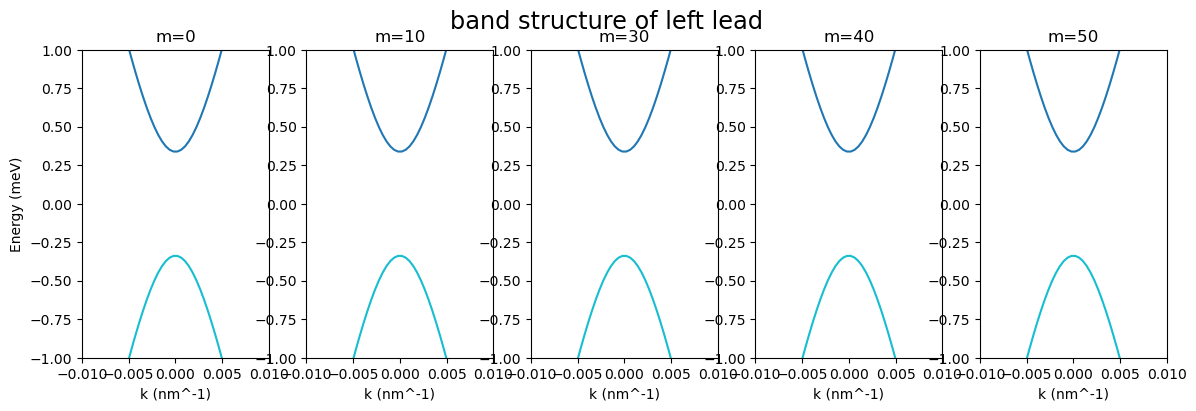

In [76]:
syst1=make_syst(m=30,c= 1,width=60, length=300).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')
a_x=0.01
ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,10,30,40,50)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-1,1)
    ax[0].set_xlim(-a_x,a_x)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-a_x, a_x, 50), ax=ax[0], params=dict(m=ax[1]));

In [48]:
syst2=make_syst(m=30,c= 1,width=5, length=25)
smat = kwant.smatrix(syst2, energy=105.0)
tmat = smat.conductance_matrix()
print("Calculated Conductance Matrix:\n", tmat)

d:\MiniforgeConda\envs\xxy\lib\site-packages\kwant\lattice.py:751: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0, 0), (0, a, 0), (0, 0, a)),


Calculated Conductance Matrix:
 [[ 0.19011214 -0.07981169 -0.02471174 -0.00997017 -0.01777995 -0.05783858]
 [-0.05783858  0.45589781 -0.06053389 -0.02471174 -0.04395074 -0.26886286]
 [-0.01777995 -0.03217727  0.45589781 -0.07981169 -0.28217815 -0.04395074]
 [-0.00997017 -0.01777995 -0.05783858  0.19011214 -0.07981169 -0.02471174]
 [-0.02471174 -0.04395074 -0.26886286 -0.05783858  0.45589781 -0.06053389]
 [-0.07981169 -0.28217815 -0.04395074 -0.01777995 -0.03217727  0.45589781]]


In [78]:
def find_voltages(tmatrix,current):  #注意：该函数返回的V是所有V的矩阵        #tmatrix是传输矩阵，在此处还未定义，current是电流分布[1, 0, 0, -1, 0, 0] 表示电流从端口1流入，端口4流出。
    try:                                                            #np.linalg.solve()函数用于求解线性方程组，返回值是一个数组，数组中的每个元素是一个未知数的解   
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])     #tmatrix[1:, 1:]表示tmatrix的第一行和第一列被删去 current[1:]表示current的第一个元素被删去  
    except np.linalg.LinAlgError as err:                            #当检测到奇异矩阵时，即该函数无解，避免程序崩溃，强制返回零电压
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]    ##在电压列表前添加一个 0，表示第一个端口的电压为0（参考接地）。
  
def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b): 
        return voltage[a-1]-voltage[b-1] ##默认电流为1 ###将端口的序号索引转化为数组索引
  
    return resistance(2, 3) ##电流从端口2流入，端口3流出，电压差为V2-V3
  
def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b):
        return voltage[a-1]-voltage[b-1]
  
    return resistance(2, 6)  

Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here
Hi there, singular matrix here


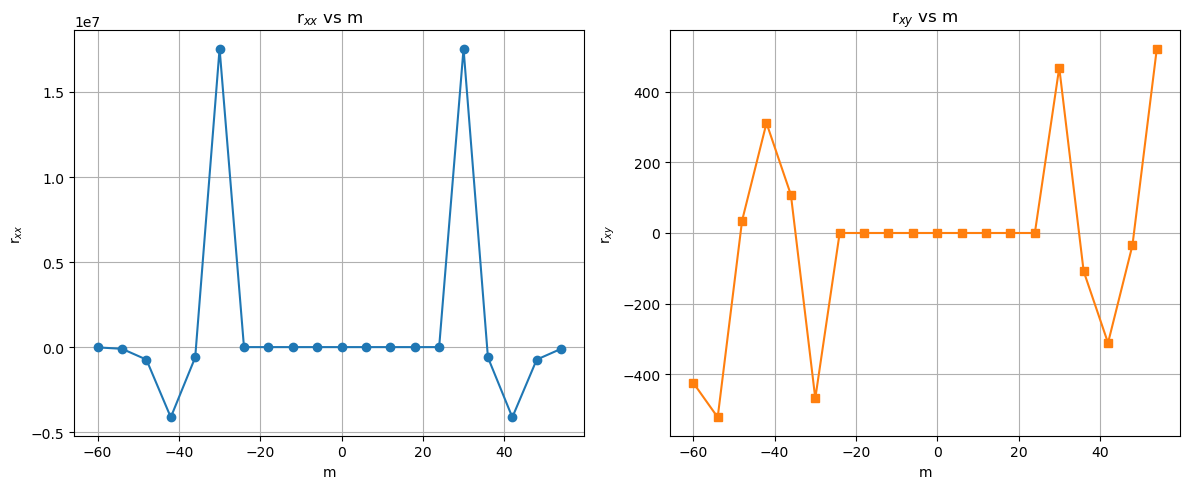

In [79]:
# 计算不同m值下的电阻
m_values = np.arange(-60, 60,6)  
rxx_list = []
rxy_list = []

for m in m_values:
    syst = make_syst(m,c=1, width=60, length=300)
    smat = kwant.smatrix(syst, energy=1.0)
    tmat = smat.conductance_matrix()
    rxx_list.append(resistance_xx(tmat))
    rxy_list.append(resistance_xy(tmat))

#画图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(m_values, rxx_list, 'o-', color='C0')
ax1.set_xlabel('m')
ax1.set_ylabel('r$_{xx}$')
ax1.set_title('r$_{xx}$ vs m')
ax1.grid(True)

ax2.plot(m_values, rxy_list, 's-', color='C1')
ax2.set_xlabel('m')
ax2.set_ylabel('r$_{xy}$')
ax2.set_title('r$_{xy}$ vs m')
ax2.grid(True)

plt.tight_layout()
plt.show()

Hi there, singular matrix here
Hi there, singular matrix here


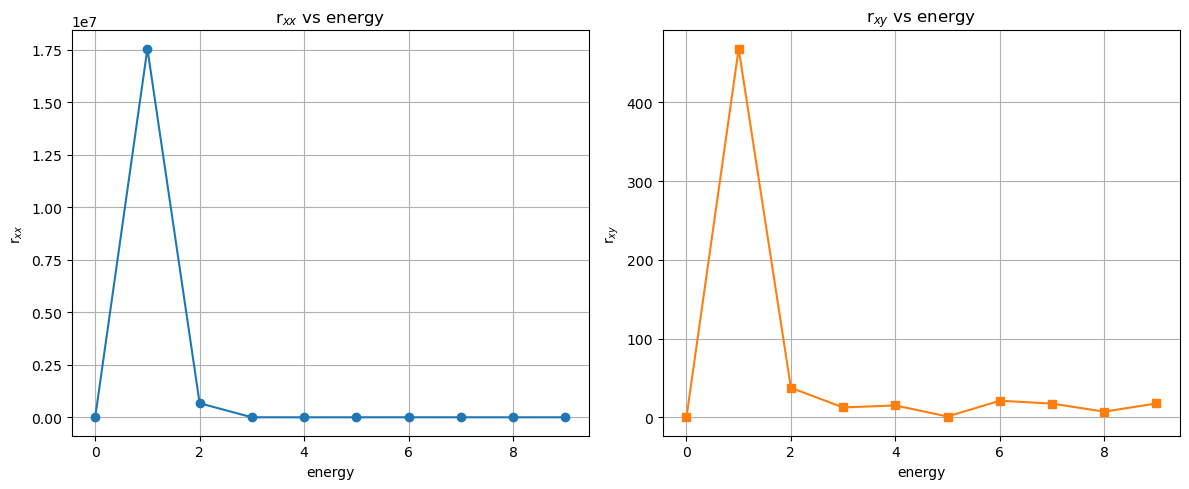

In [74]:
# 计算不同energy值下的电阻
energy_values = np.arange(0, 10,1)  
rxx_list = []
rxy_list = []

for energy in energy_values:
    syst = make_syst(m=30, c=1,width=60, length=300)
    smat = kwant.smatrix(syst, energy)
    tmat = smat.conductance_matrix()
    rxx_list.append(resistance_xx(tmat))
    rxy_list.append(resistance_xy(tmat))

#画图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(energy_values, rxx_list, 'o-', color='C0')
ax1.set_xlabel('energy')
ax1.set_ylabel('r$_{xx}$')
ax1.set_title('r$_{xx}$ vs energy')
ax1.grid(True)

ax2.plot(energy_values, rxy_list, 's-', color='C1')
ax2.set_xlabel('energy')
ax2.set_ylabel('r$_{xy}$')
ax2.set_title('r$_{xy}$ vs energy')
ax2.grid(True)

plt.tight_layout()
plt.show()